In [1]:
import uproot
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hist
import re

# Define a list of ROOT files to open
root_file_list = glob.glob('/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/e_scans/*.0*.root')

# Define a list of keys (TKeys) to extract data from
#efficiency not working properly, TEfficiency sucks
keys_to_extract = ["EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawValues",
        "ClusteringSpatial/RD50_MPW3_base_0/clusterSize",
        "AnalysisDUT/RD50_MPW3_base_0/local_residuals/residualsX"]

x_name = 'Beam Energy (GeV)'
x_regex = r'(\d\.\d)GeV'

root_file_list




['/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/e_scans/ana_e_1317_5.0GeV.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/e_scans/ana_e_1314_2.0GeV.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/e_scans/ana_e_1313_1.0GeV.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/e_scans/ana_e_1315_3.0GeV.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/e_scans/ana_e_1316_4.0GeV.root',
 '/home/bernhard/hephy/mpw3/data/testbeam/desy_jul23/corry_desy/e_scans/ana_e_1318_6.0GeV.root']

In [2]:
# Create an empty DataFrame to store the results
# results_df = pd.DataFrame(columns=["File", "Key", "Mean", "StdDev"])
results = {"File" : [], "Key" : [], "xVal" : [], "Mean" : [], "StdDev": [], "StdErr" : [], "N" :[] }

# Loop over each ROOT file
for root_file in root_file_list:
    # Open the ROOT file using uproot
    with uproot.open(root_file) as file:
        # Loop over each key to extract data
        for key_name in keys_to_extract:
            try:
                # Access the TKey using the key name
                tkey = file[key_name]
                mean_val = 0
                std_dev_val = 0
                N = 0
                # Check if the TKey points to a TH1F histogram
                if isinstance(tkey, uproot.uproot.behaviors.TH1.TH1):
                    hist_data = tkey.to_hist()
                    hist_np = tkey.to_numpy() # [0] ... bins, [1] ... weights
                    #hist_data.plot()
                    plt.show()
                    unjagged_bins = (hist_np[1][:-1] + hist_np[1][1:]) / 2
                    N = np.sum(hist_np[0])
                    mean_val = np.sum(hist_np[0] * unjagged_bins) / N
                    #print('mean = ', mean_val)                    
                    std_dev_val = np.sqrt(np.sum(hist_np[0] * (unjagged_bins - mean_val)**2) / N)
                    #print('std', std_dev_val)
                else:
                    continue

            
                results["xVal"].append(float(re.search(x_regex, root_file).group(1)))
                results["Mean"].append(mean_val)
                results['StdDev'].append(std_dev_val)
                results['File'].append(root_file)
                results['Key'].append(key_name)
                results["N"].append(N)
                results["StdErr"].append(std_dev_val / np.sqrt(N))

            except KeyError:
                print(f"Key '{key_name}' not found in file '{root_file}'")

df = pd.DataFrame(results)
df

,File,Key,xVal,Mean,StdDev,StdErr,N
0,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,5.0,5.538834,29.304343,0.108554,72874.0
1,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,ClusteringSpatial/RD50_MPW3_base_0/clusterSize,5.0,1.066969,0.327054,0.001251,68300.0
2,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,AnalysisDUT/RD50_MPW3_base_0/local_residuals/r...,5.0,2.310328,21.230360,0.103933,41726.0
3,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,2.0,7.043176,34.942785,0.081782,182557.0
4,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,ClusteringSpatial/RD50_MPW3_base_0/clusterSize,2.0,1.066556,0.379381,0.000917,171165.0
5,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,AnalysisDUT/RD50_MPW3_base_0/local_residuals/r...,2.0,1.878244,22.554730,0.120048,35299.0
6,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,1.0,5.463705,29.125684,0.140419,43023.0
7,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,ClusteringSpatial/RD50_MPW3_base_0/clusterSize,1.0,1.065189,0.327926,0.001632,40390.0
8,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,AnalysisDUT/RD50_MPW3_base_0/local_residuals/r...,1.0,3.100010,25.348657,0.505861,2511.0
9,/home/bernhard/hephy/mpw3/data/testbeam/desy_j...,EventLoaderEUDAQ2/RD50_MPW3_base_0/hPixelRawVa...,3.0,7.680757,37.028457,0.107516,118612.0


In [3]:
def annotate_points(df, col_name):
    for index, row in df.iterrows():
        plt.annotate(f'{row["Mean"]:.3f}', (row['xVal'], row["Mean"]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

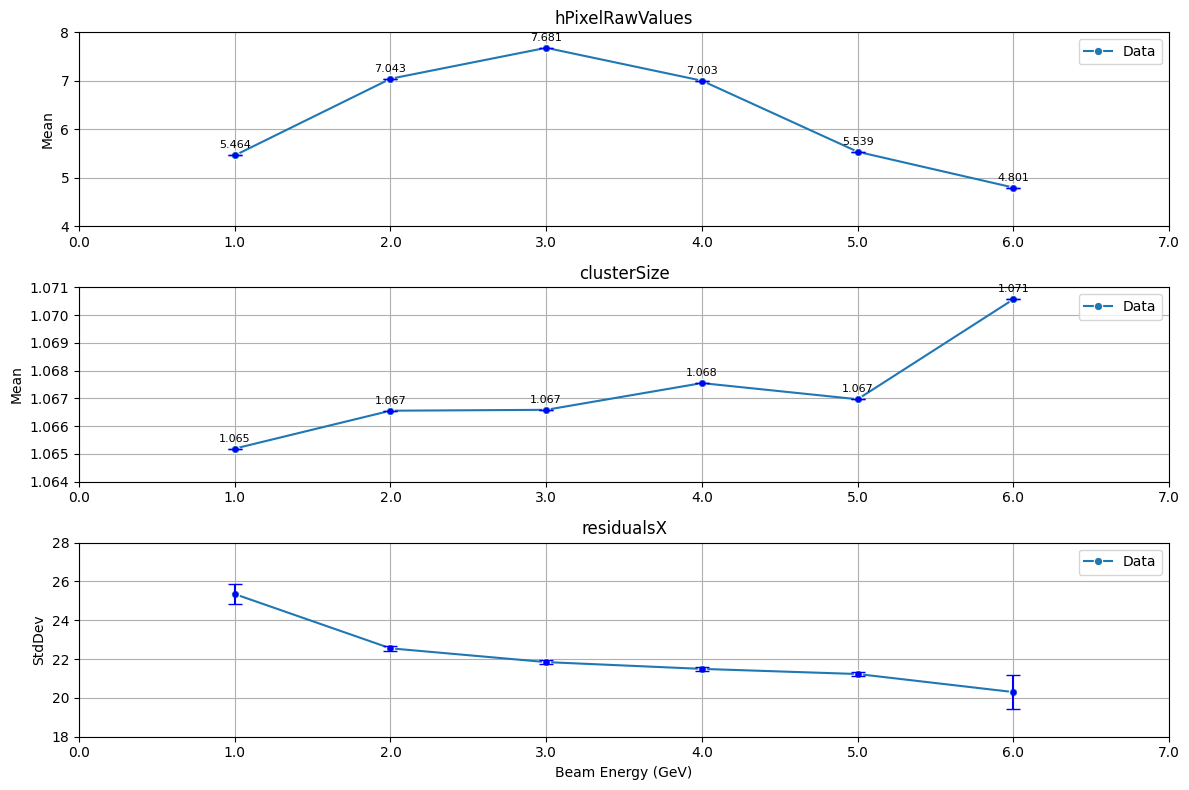

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your existing code for creating subplots
plt.figure(figsize=(12, 8))

for i, key in enumerate(keys_to_extract):
    keyrows = df[df['Key'].str.contains(key)]  # Get sub dataframe where all rows containing the current key are in
    plt.subplot(3, 1, i + 1)
    
    x = keyrows['xVal']
    y = keyrows['Mean']
    if 'residuals' in key:
        y = keyrows['StdDev']
    
    # Create separate DataFrames for error bars (yerr)
    if i == len(keys_to_extract) - 1:
        yerr = df[df['Key'].str.contains(key)]['StdErr'].values  # Use StdErr values for the last subplot
    else:
        yerr = np.zeros_like(y)  # Set yerr as zeros for other subplots
    
    # Plot a line plot with error bars
    sns.lineplot(x=x, y=y, label='Data', marker='o')
    plt.errorbar(x, y, yerr=yerr, fmt='.', color='blue', capsize=5)  # Add error bars
    
    plt.xlabel('')
    plt.title(key.split('/')[-1])
    annotate_points(df, key)

    # Add grid lines for both x-axis and y-axis in all subplots
    plt.grid(True, which='both')

    # Set y-ticks for all subplots
    plt.gca().set_yticks(plt.gca().get_yticks())

    ax = plt.gca()  # Get the current axis (last subplot)
    ax.set_xticks(ax.get_xticks())  # This line refreshes the tick locations
    ax.set_xticklabels(ax.get_xticks())  # Set tick labels to be the same as tick locations

plt.xlabel(x_name)
# Adjust layout
plt.tight_layout()

plt.show()
